In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from eurybia import SmartDrift
from sklearn.ensemble import RandomForestRegressor

/home/jubuntu/anaconda3/envs/mlops_putain_de_merde/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Modèle en production

Laurent Cetinsoy - Datadidacte

Une des supposition centrale pour qu'un modèle de machine learning marche est que la distribution des données ne diffère pas de celle des données d'entrainement.

On ne peut garantir la généralisation d'un modèle que si la distribution des données est similaire à celle de la distribution $ X_{prod} \tilde{} \,  P_{train}$

Ainsi, si les données que le modèle voient en production n'ont pas la même distribution (ne ressemblent pas) aux données de train, alors le modèle aura peu de chance de faire de bonne prédictions.

Il est donc important de surveille les données vues par le modèle en production.

Pour cela on va mesurer ce qu'on appelle le Data drift : on va mesurer à quel point les données s'écartent des données de train.

Et on pourra ainsi lever une alerte si c'est le cas.

## Utilisation Eurybia



En consultant la documentation de Eurybia (https://eurybia.readthedocs.io/en/latest/overview.html), expliquer le principe de fonctionnement de Euribya :

- A quoi sert le modèle de classification ?
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?
- Quel est le critère pour déterminer qu’il y a un data-drift ?


- Le modèle de classification sert à prédire si un échantillon de données est issu de la distribution de données d'entrainement ou non.
- Non.
- Le critère pour déterminer qu'il y a un data-drift est la probabilité de rejet. Si cette probabilité est supérieure à un seuil donné, alors il y a un data-drift.

Installer eurybia

In [2]:
! pip install eurybia

Utiliser eurybia pour monitorer le modèle. Dans un premier temps faire en sorte que les données (df_current) soient de la même distribution que vos données d’entraînement. Vérifier que Eurybia pense que le modèle ne drift pas


In [3]:
df_current = pd.read_csv("./data/houses.csv")
df_current.head()

,size,nb_rooms,garden,orientation,price
0,205.999169,2,0,Ouest,260972.164975
1,186.559166,2,0,Ouest,256534.245748
2,187.143785,1,1,Est,282674.291717
3,83.315363,2,1,Est,266555.384156
4,161.781580,2,1,Sud,319158.418695


In [11]:
df_current["orientation"] = df_current["orientation"].map(
    {"Ouest": 1, "Est": 2, "Sud": 3, "Nord": 4}
)

In [16]:
df_train, df_test = train_test_split(df_current, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(max_depth=2, random_state=0)
regressor.fit(df_train[["size", "nb_rooms", "garden", "orientation"]], df_train["price"])

sd = SmartDrift(
    df_current=df_current[["size", "nb_rooms", "garden", "orientation"]],
    df_baseline=df_train[["size", "nb_rooms", "garden", "orientation"]],
    deployed_model=regressor,
    dataset_names={
        "df_current": "Current dataset Name",
        "df_baseline": "Baseline dataset Name",
    },
)

sd.compile()

sd.generate_report(
    output_file="./data/report_train.html",
    title_story="Data drift",
)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7f328b980da0>


Faire de même avec des données de test. Les données de tests ont-elle un drift par rapport au train ?


In [17]:
sd = SmartDrift(
    df_current=df_current[["size", "nb_rooms", "garden", "orientation"]],
    df_baseline=df_test[["size", "nb_rooms", "garden", "orientation"]],
    deployed_model=regressor,
    dataset_names={
        "df_current": "Current dataset Name",
        "df_baseline": "Baseline dataset Name",
    },
)

sd.compile()

sd.generate_report(
    output_file="./data/report_test.html",
    title_story="Data drift",
)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7f3299860da0>


Générer des données qui ne ressemblent ni au train ni au test (par exemple avec des données abérentes). Euribya détecte-t-il ces données ?

In [26]:
generated_data = pd.DataFrame(
    {
        "size": [1000.1, 2000.2, 3000.3, 4000.4, 5000.5, 6000.6],
        "nb_rooms": [500, 4, 30, 800, 5000, 60000],
        "garden": [4, 1, 5, 10, 40, 66],
        "orientation": [1, 2, 3, 4, 1, 2],
        "price": [1000, 2000, 3000, 4000, 5000, 1],
    }
)
generated_data

,size,nb_rooms,garden,orientation,price
0,1000.1,500,4,1,1000
1,2000.2,4,1,2,2000
2,3000.3,30,5,3,3000
3,4000.4,800,10,4,4000
4,5000.5,5000,40,1,5000
5,6000.6,60000,66,2,1


In [27]:
features = ["size", "nb_rooms", "garden", "orientation"]

sd = SmartDrift(
    df_current=df_current[features],
    df_baseline=generated_data[features],
    deployed_model=regressor,
    dataset_names={
        "df_current": "Current dataset Name",
        "df_baseline": "Baseline dataset Name",
    },
)

sd.compile()

sd.generate_report(
    output_file="./data/report_generated_data.html",
    title_story="Data drift",
)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7f3299efbb00>


## Alibaba detect

Dans cette partie on va utiliser la librairie https://github.com/SeldonIO/alibi-detect pour faire la détection de problèmes
Installer la librairie avec pip

In [28]:
! pip install alibi-detect

  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 7.6 MB/s eta 0:00:00a 0:00:01
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 7.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0

Charger le jeu de donnée cifar10 avec keras et récupérer le train et le test puis,

Normaliser les données de train en faisant un MinMaxScaling (diviser par 255)

In [14]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32")
x_train /= 255

x_test = x_test.astype("float32")
x_test /= 255

Dans le sous package alibbi_detect.datasets importer les  fonction fetch_cifar10c et corruption_types_cifar10c

In [3]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Afficher les types de corruption de données disponible avec la fonction corruption_types_cifar10c

In [4]:
corruption_types_cifar10c()

['brightness',
 'contrast',
 'defocus_blur',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur']

Avec la fonction fetch_cifar10c récupérer des exemples corrompus de donnée ressemblant à cifar 10 et les stocker dans des variable X_corrupted et y_corrupted.

Vous choisirez au moins les corruptions suivantes : ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

Vous spécifirez les argument severity=5 et return_X_y=True

In [6]:
X_corrupted, y_corrupted = fetch_cifar10c(corruption=['gaussian_noise', 'motion_blur', 'brightness', 'pixelate'], severity=5, return_X_y=True)

Normaliser les images corrompues

In [7]:
X_corrupted = X_corrupted.astype("float32")
X_corrupted /= 255

Afficher plusieurs des images corrompues.

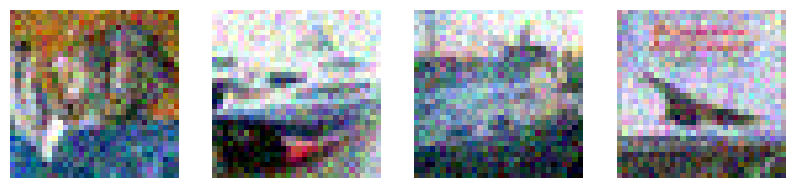

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.imshow(X_corrupted[i])
    ax.axis("off")
plt.show()

On va maintenant prendre un modèle entraîné sur cifar10 pour voir l'impact des performances sur le modèle.

Avec la fonction  fetch_tf_model du module alibi_detect.utils.fetching, charger le modèle préentraîné resnet32 sur cifar10


In [9]:
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
dataset = 'cifar10'
model_name = 'resnet32'
model = fetch_tf_model(dataset, model_name)

4293464/4293464 [==============================] - 4s 1us/step


Calculer la performance du model sur le jeu de train et de test

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=1)
model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/10
782/782 [==============================] - 105s 128ms/step - loss: 0.3840 - accuracy: 0.9185
Epoch 2/10
782/782 [==============================] - 109s 140ms/step - loss: 0.3599 - accuracy: 0.9343
Epoch 3/10
782/782 [==============================] - 109s 140ms/step - loss: 0.3662 - accuracy: 0.9379
Epoch 4/10
782/782 [==============================] - 110s 141ms/step - loss: 0.3727 - accuracy: 0.9434
Epoch 5/10
782/782 [==============================] - 110s 141ms/step - loss: 0.3738 - accuracy: 0.9469
Epoch 6/10
782/782 [==============================] - 110s 141ms/step - loss: 0.3779 - accuracy: 0.9502
Epoch 7/10
782/782 [==============================] - 110s 141ms/step - loss: 0.3812 - accuracy: 0.9519
Epoch 8/10
782/782 [==============================] - 109s 139ms/step - loss: 0.3837 - accuracy: 0.9541
Epoch 9/10
782/782 [==============================] - 110s 141ms/step - loss: 0.3852 - accuracy: 0.9556
Epoch 10/10
79/79 [==============================] - 7s 81ms/ste

[0.9479143619537354, 0.8101000189781189]

Calculer la performance du modèle sur le jeu de donnée corrompu. Vous devriez observer qu'il chute significativement

In [16]:
model.evaluate(X_corrupted, y_corrupted, batch_size=128)

313/313 [==============================] - 26s 81ms/step - loss: 2.8151 - accuracy: 0.4325


[2.8150522708892822, 0.4324750006198883]

On va maintenant voir comment détecter les changement de distributions de données.

Pour les données non tabulaire ou à haute dimension on procéde généralement en deux étapes :

1. Faire une réduction de dimension
2. Faire un test permettant de voir si les données projetées ont changé de distribution ou pas

Il existe plusieurs manières de faire de la réduction de dimension. La plus classique est la PCA.

Il est possible également d'utiliser des Auto-encoder

Le code suivant permet de créer la première partie (l'encoder) d'un auto-encoder simple qui nous servira à réduire les dimension des données.

In [20]:
from functools import partial
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer

tf.random.set_seed(0)

encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

Le drift detector a besoin d'une donnée de référence afin d'effectuer la comparaison avec les données à monitorer.
Créer une variable X_ref avec un échantillon aléatoire des données de test

In [21]:
X_ref = x_test[np.random.choice(x_test.shape[0], 100, replace=False)]

A quoi sert le test statistique kolmogorov smirnoff ?

Le test kolmogorov smirnoff sert à tester si deux échantillons de données ont la même distribution.

Instancier la classe KSDrift dans une variable nommée **detector**

Il faut lui passer le dataset de reference, une p value (prendre 0.05) et une fonction permettant de faire le preprocessing. On a créé la fonction pour vous


In [22]:
from alibi_detect.cd.tensorflow import preprocess_drift
preprocess_function = partial(preprocess_drift, model=encoder_net, batch_size=32)

A laide du Drift detector et la méthode predict faire des prediction sur les données de test et sur les données corrompue pour voir si il détecte un changement de distribution

In [30]:
from alibi_detect.cd import KSDrift

cd = KSDrift(
    p_val=.05,
    x_ref=X_ref,
    preprocess_fn=preprocess_function,
)

cd.predict(X_corrupted)


{'data': {'is_drift': 1,
  'distance': array([0.098975, 0.18735 , 0.104825, 0.2549  , 0.186325, 0.14285 ,
         0.246725, 0.079475, 0.133725, 0.21165 , 0.201375, 0.237075,
         0.108725, 0.244775, 0.218775, 0.049   , 0.164075, 0.172425,
         0.14445 , 0.14025 , 0.149575, 0.221575, 0.234325, 0.20895 ,
         0.0738  , 0.200775, 0.0881  , 0.1975  , 0.1092  , 0.060225,
         0.123125, 0.24915 ], dtype=float32),
  'p_val': array([2.6334921e-01, 1.5141725e-03, 2.0678420e-01, 3.2419875e-06,
         1.6375859e-03, 3.0398786e-02, 7.5709140e-06, 5.2664775e-01,
         5.0832868e-02, 2.0760307e-04, 4.9581443e-04, 1.9848048e-05,
         1.7458770e-01, 9.2287455e-06, 1.1056894e-04, 9.6039033e-01,
         8.0531547e-03, 4.5378357e-03, 2.7680628e-02, 3.5317376e-02,
         2.0360878e-02, 8.5810709e-05, 2.5929738e-05, 2.6209923e-04,
         6.2051785e-01, 5.2095228e-04, 3.9653915e-01, 6.8057224e-04,
         1.7095144e-01, 8.3970189e-01, 8.8498935e-02, 5.9048025e-06],
        dt